# Signal fitting with QML & ML

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.optimize as sci

from scipy.ndimage import gaussian_filter
from scipy import signal
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from numpy import random

from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score, r2_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from qiskit.opflow import PauliSumOp
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
from qiskit_machine_learning.kernels import QuantumKernel
#from qiskit_machine_learning.neural_networks import CircuitQNN
#from qiskit.opflow.gradients import Gradient
#from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.wrappers.scikit_learn import KerasRegressor

import time
import warnings
warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42
np.random.seed(100)
np.random.default_rng(100)

Instructions for updating:
non-resource variables are not supported in the long term


Generator(PCG64) at 0x1E71B371D68

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
fano_data.head()

,# signal_id,signal_original_x,signal_original_y,signal_fano_y,peak_xcoord,peak_ycoord,w,A,y0,xc,q,b_field
0,81.0,4.199235e+09,-0.000500,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
1,81.0,4.199248e+09,-0.000501,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
2,81.0,4.199261e+09,-0.000502,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
3,81.0,4.199274e+09,-0.000503,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
4,81.0,4.199287e+09,-0.000504,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024


In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

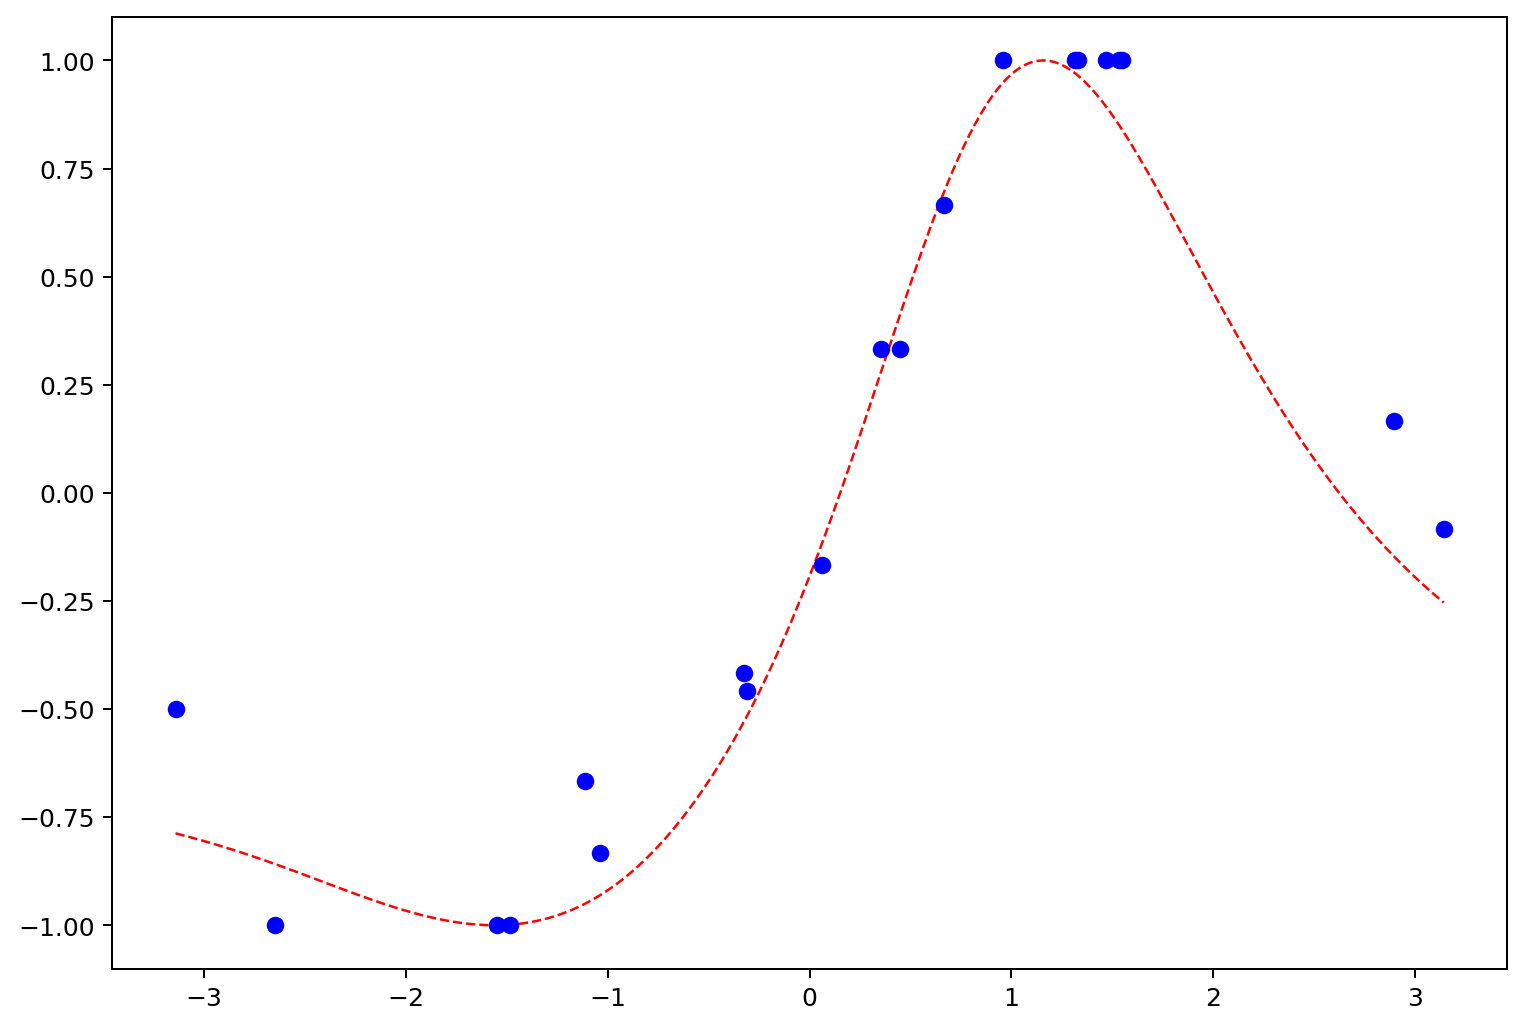

In [5]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = signal.detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.show()

In [6]:
# dummy data
#num_samples = 20
#eps = 0.2
#lb, ub = -np.pi, np.pi
#X_ = np.linspace(lb, ub, num=50).reshape(50, 1)

#f = lambda x:  1/(1 + np.exp(-x)) # sigmoid (dummy data)

#y_ = f(X_)

#X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
#y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

In [7]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

# Fitting with scipy.curve_fit

In [8]:
def fano_func(x, y0, A, xc, w, q):

    res = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)

    return res

def fano_errfunc(guess, x, y):

    y0 = guess[0]
    A = guess[1]
    xc = guess[2]
    w = guess[3]
    q = guess[4]
    
    res = y - fano_func(x, y0, A, xc, w, q)

    return res

def perform_fano_adjust(x, y, y0_guess, A_guess, xc_guess, w_guess, q_guess, lb, ub):

    guess = [y0_guess, A_guess, xc_guess, w_guess, q_guess]

    #return sci.least_squares(fano_errfunc, guess, args=(x,y), bounds=(lb, ub)) # works
    #return sci.leastsq(fano_errfunc, guess, args=(x,y), maxfev=100000)
    return sci.curve_fit(fano_func, x, y, guess, bounds=(lb, ub), maxfev=1000000)

In [9]:
A_adjust = 0.020
w_adjust = 11e4
q_adjust = 2.0
xc_param_adjust = fano_data["xc"].values[0]

low_bound = []
up_bound = []

x_sci = fano_data["signal_original_x"].values.reshape(-1,1)[:,0]
y_sci = fano_data["signal_original_y"].values.reshape(-1,1)[:,0] 
#y_sci = f(x_sci.reshape(-1,1))[:,0]

y0_adjust = -A_adjust*(-2*xc_param_adjust/w_adjust+q_adjust)**2/(1+(2*xc_param_adjust/w_adjust)**2)*1/(1+q_adjust**2)

fitparams, pcov = perform_fano_adjust(x_sci, y_sci, y0_adjust, A_adjust, xc_param_adjust, w_adjust, q_adjust, low_bound, up_bound)

fano_adjust_result = fano_func(x_sci, *fitparams)

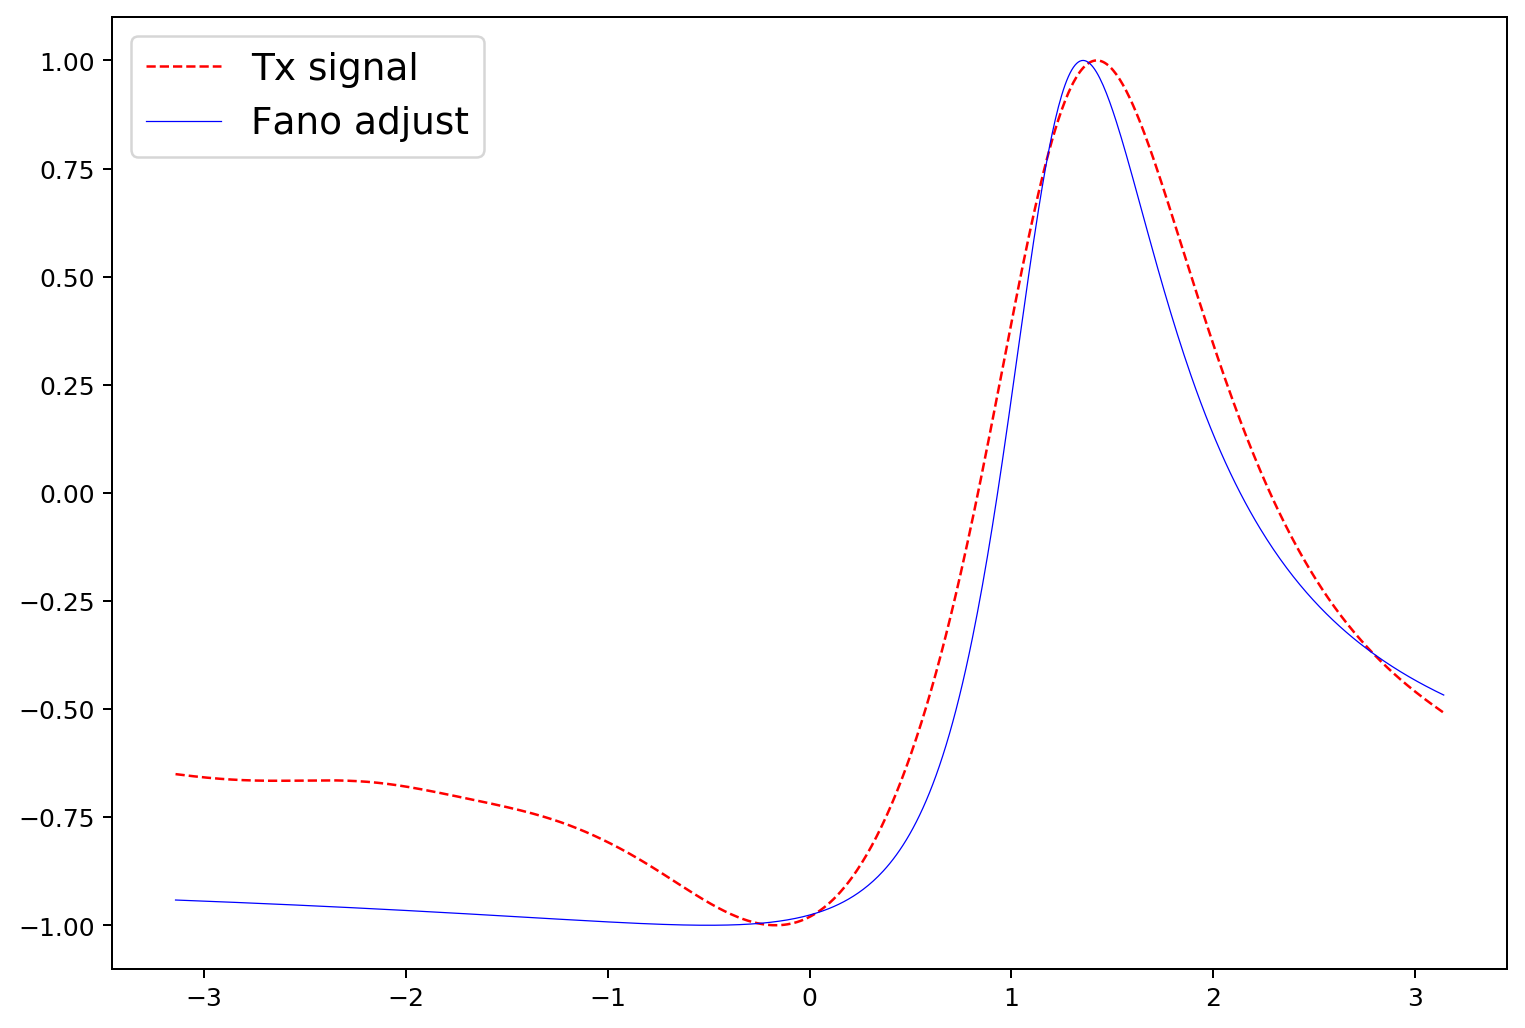

In [10]:
x_sci = scale(x_sci)
y_sci = scale(y_sci, -1, 1)

fano_adjust_result = scale(fano_adjust_result, -1, 1)

fano_adjust_result = scale(fano_adjust_result, lvalue = -1, rvalue = 1)
plt.figure(num = "Fano adjust single", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
        
plt.plot(x_sci, y_sci, 'r--',  label='Tx signal', linewidth = 1)
plt.plot(x_sci, fano_adjust_result, 'r-', color="blue", linewidth = 0.5, label = 'Fano adjust')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

# Classical Machine Learning

In [11]:
svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

In [12]:
train_size = 100
t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("")
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("")
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X)
svr_predict = time.time() - t0
print("")
print("SVR prediction for %d inputs in %.3f s" % (X.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X.shape[0], kr_predict))


Best SVR with params: {'C': 10.0, 'gamma': 0.1} and R2 score: -0.343
SVR complexity and bandwidth selected and model fitted in 0.127 s

Best KRR with params: {'alpha': 0.1, 'gamma': 0.1} and R2 score: -0.221
KRR complexity and bandwidth selected and model fitted in 0.106 s
Support vector ratio: 0.090

SVR prediction for 20 inputs in 0.000 s
KRR prediction for 20 inputs in 0.001 s


In [13]:
#model = SVR(kernel="rbf", gamma=9.0, C=9.0)

model = KernelRidge(kernel="rbf", gamma=1.0, alpha = 0.01)
model.fit(X, y)

KernelRidge(alpha=0.01, gamma=1.0, kernel='rbf')

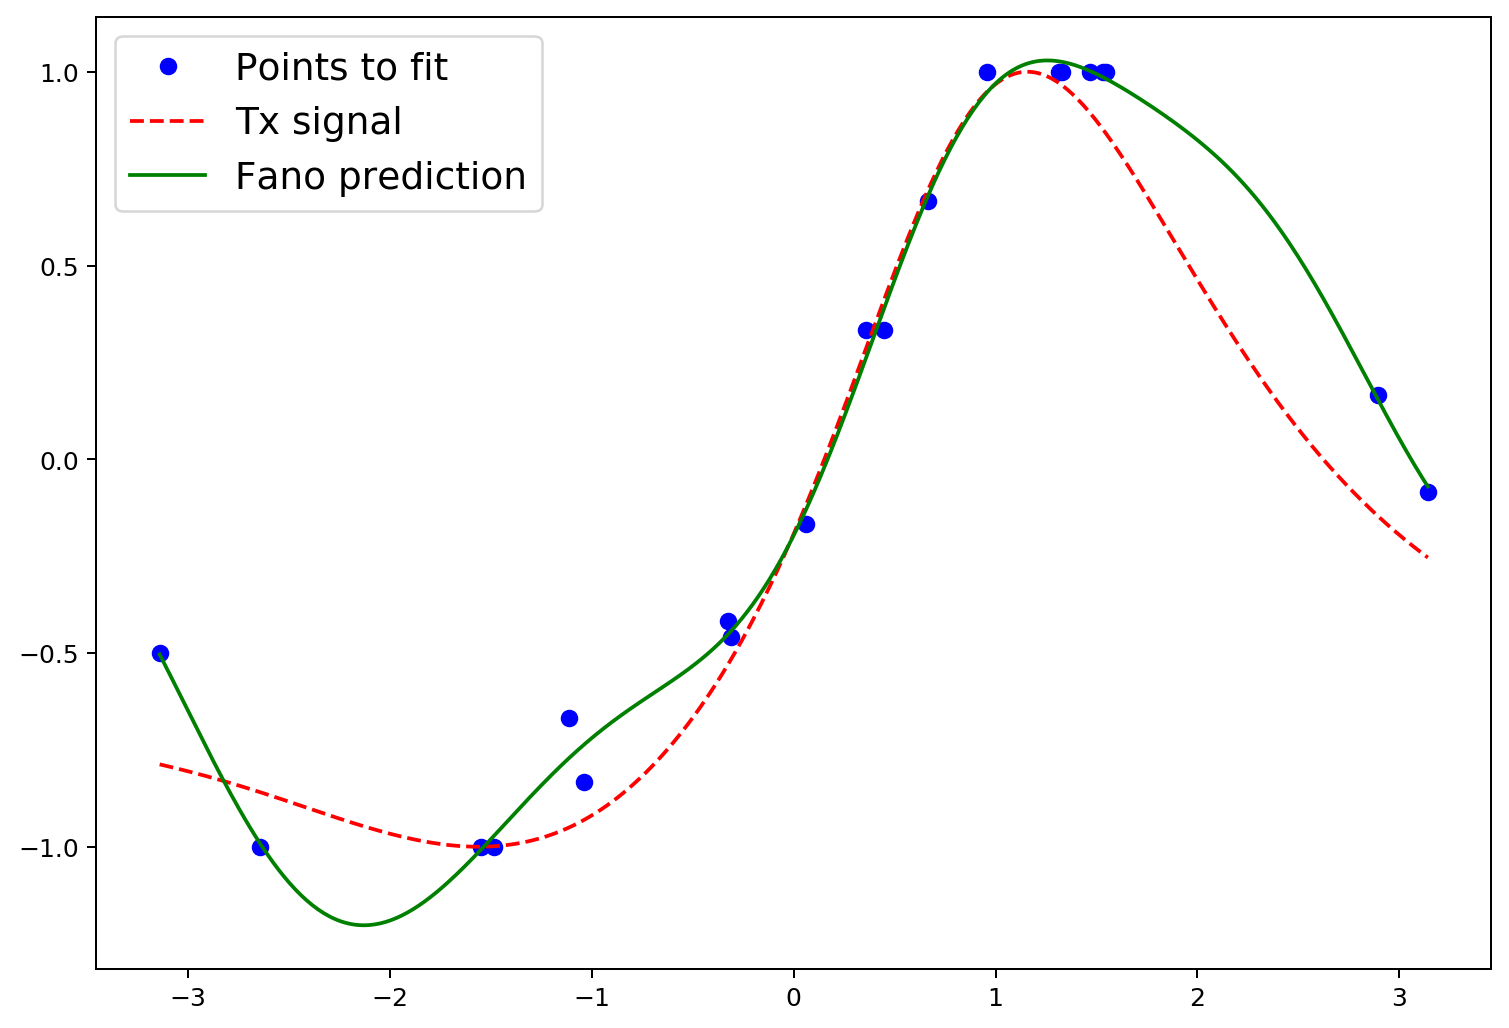

In [14]:
plt.figure(num = "Fano adjust ML", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = model.predict(X_)
plt.plot(X_, y_predict, "g-", label = 'Fano prediction')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [15]:
model.score(X, y)

0.9966249952996933

# Quantum Machine Learning Regressors

## Quantum Neural Network Regressor

In [16]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [17]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

observable = PauliSumOp.from_list([("Z" * 1, 0.8)])

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, observable = observable, quantum_instance=quantum_instance)

In [18]:
# define (random) input and weights
input3 = algorithm_globals.random.random(regression_opflow_qnn.num_inputs)
weights3 = algorithm_globals.random.random(regression_opflow_qnn.num_weights)

In [19]:
# QNN forward pass
regression_opflow_qnn.forward(input3, weights3)

# QNN forward pass
regression_opflow_qnn.forward(input3, weights3)

array([[0.2359375]])

In [20]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [21]:
initial_point = algorithm_globals.random.random(ansatz.num_parameters)

# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(),
    #optimizer=COBYLA(400),
    #initial_point = initial_point,
    callback=callback_graph,
)

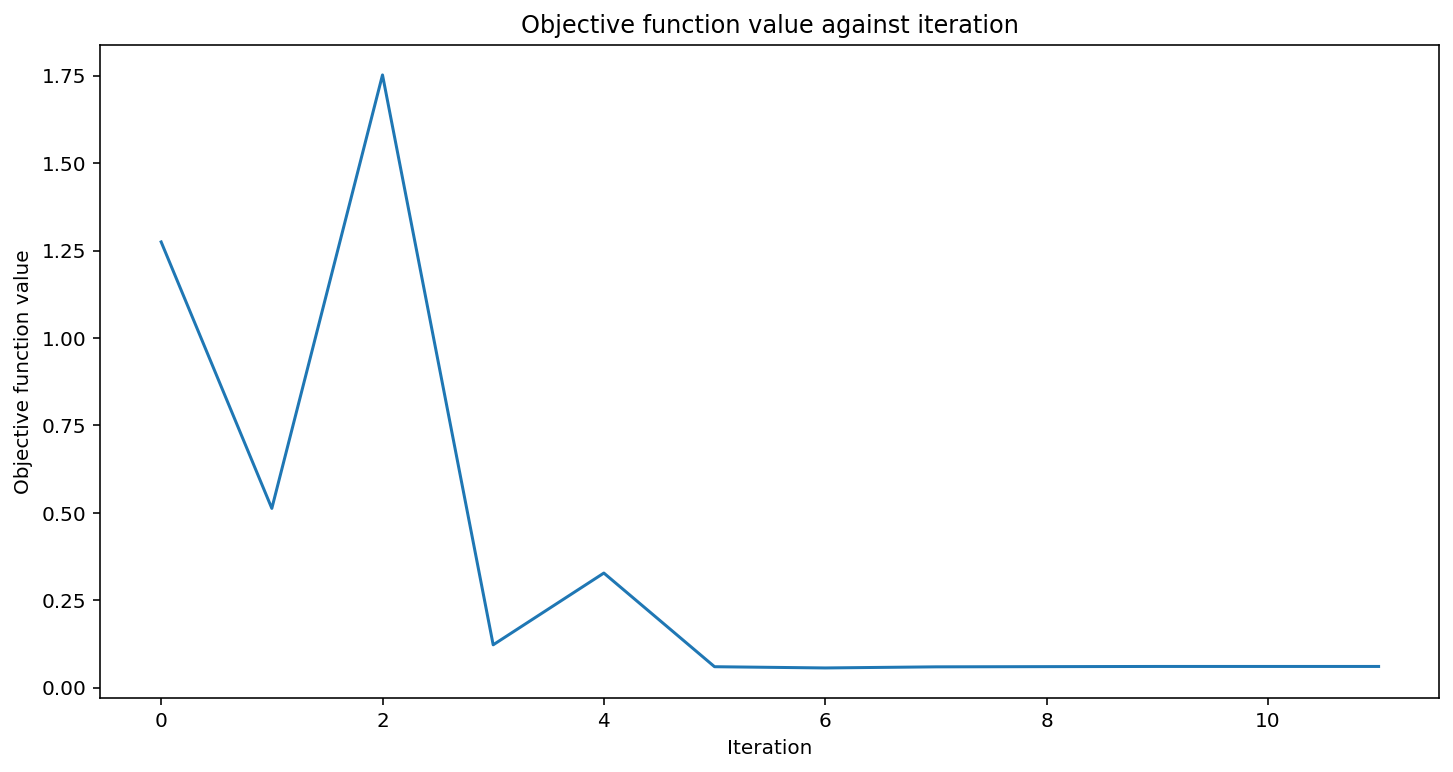

0.8986280400803586

In [22]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y.reshape(-1,1))

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score the result
regressor.score(X, y)

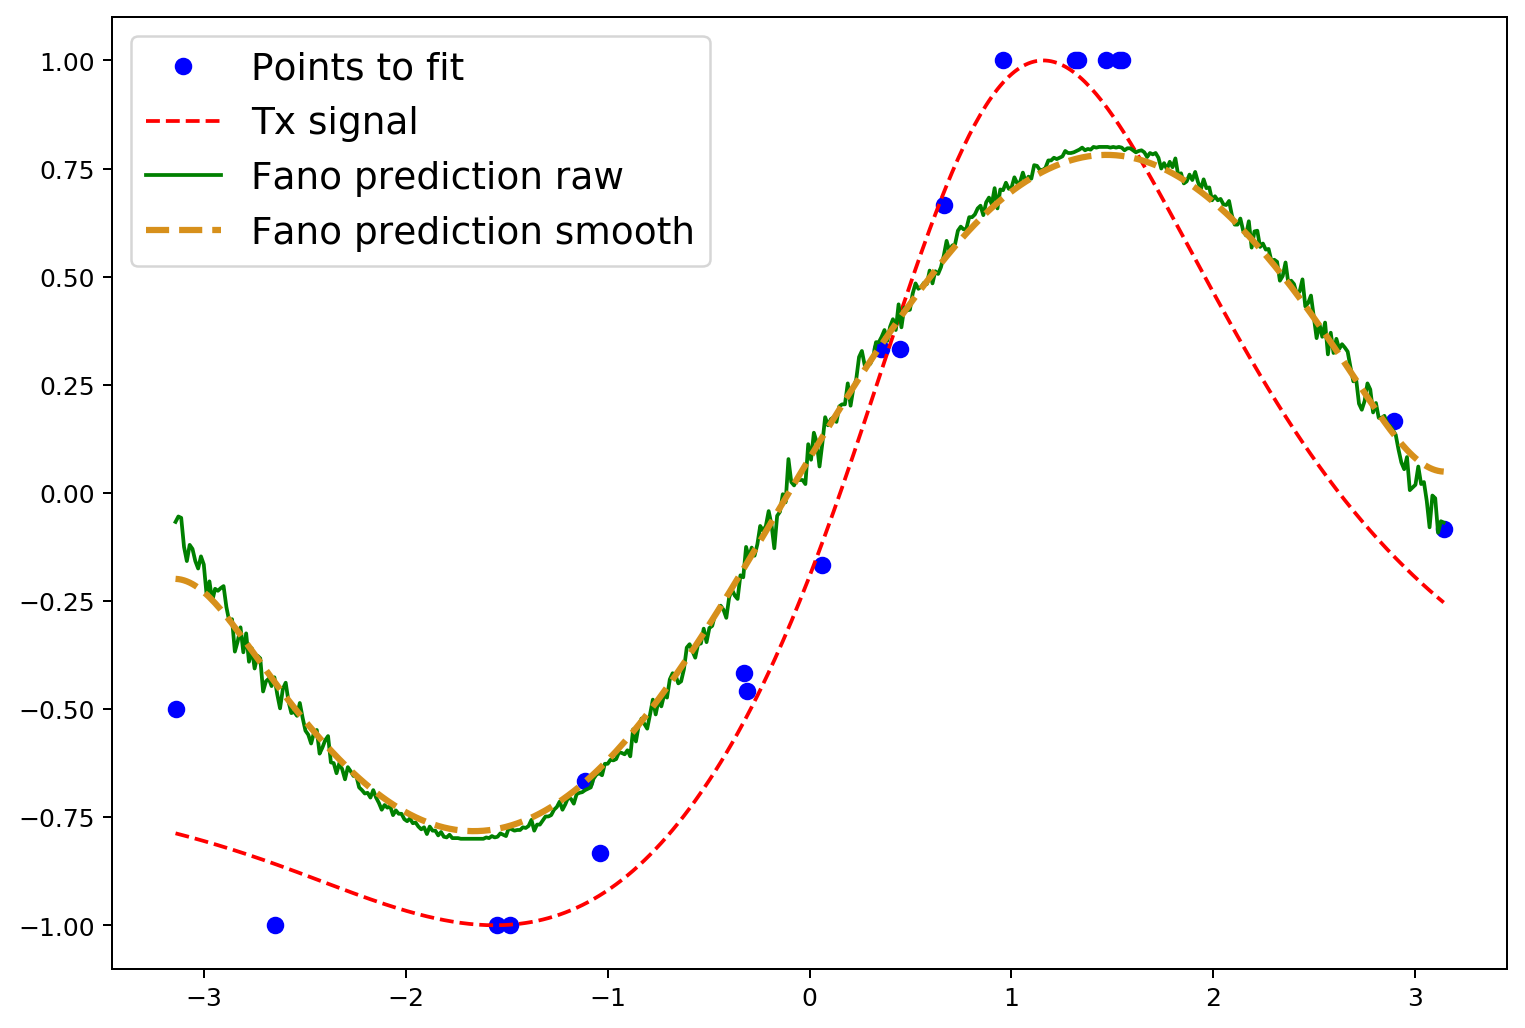

In [23]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = regressor.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

## Variational Quantum Regressor

In [24]:
initial_point = algorithm_globals.random.random(ansatz.num_parameters)

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    #initial_point = initial_point,
    callback=callback_graph,
)

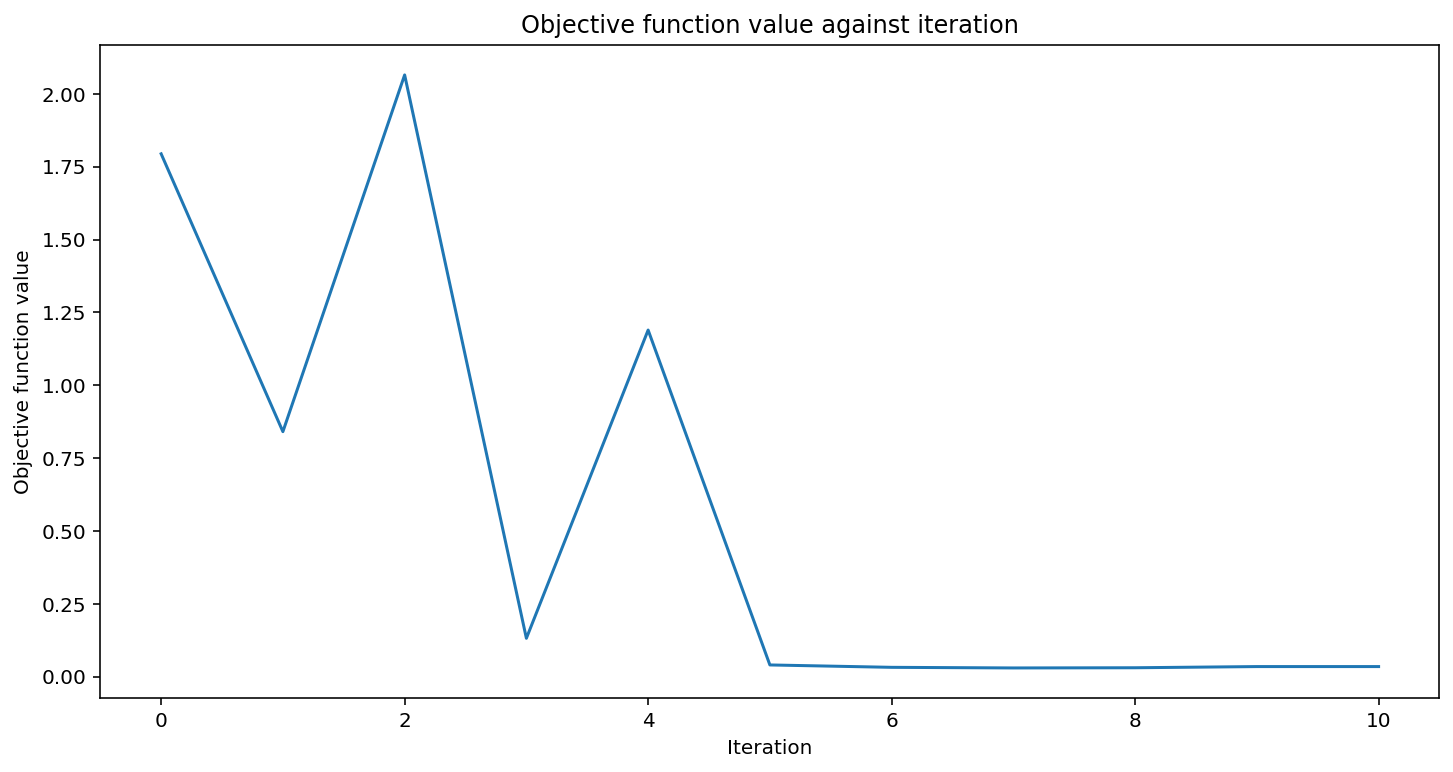

0.9336948016385614

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score result
vqr.score(X, y)

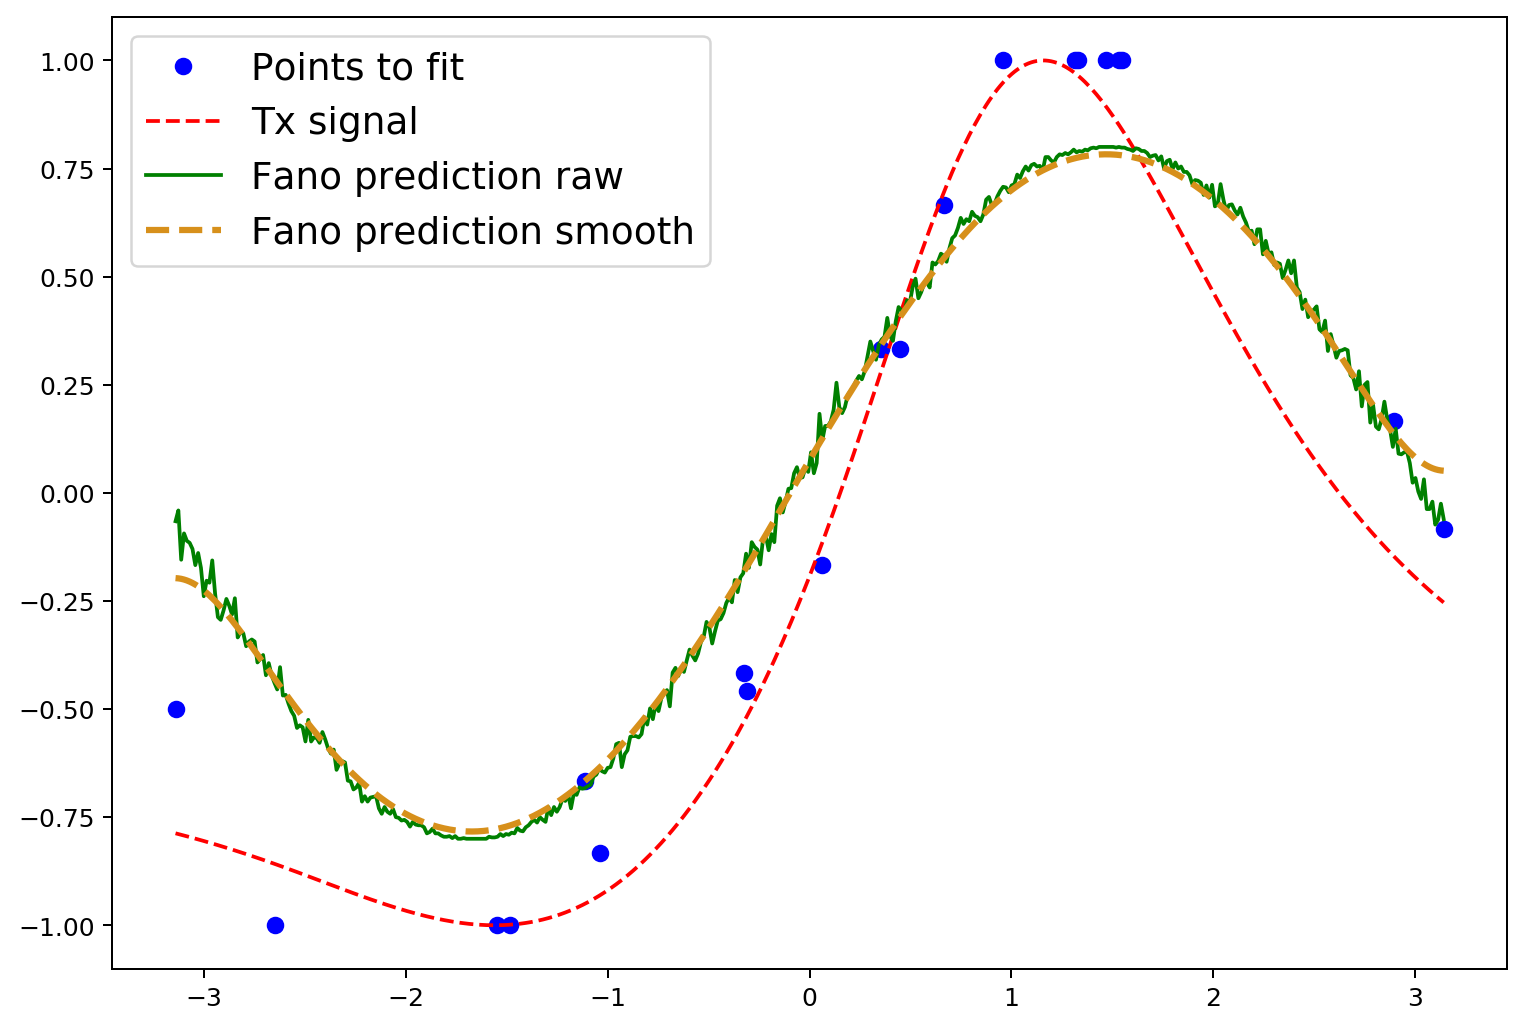

In [26]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = regressor.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

## Quantum Support Vector Regressor

In [49]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
#qkernel.evaluate(x_vec=X)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X, y)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002031E27E9C8>,
     shrinking=True, tol=0.001, verbose=False)

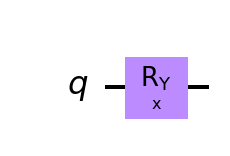

In [50]:
feature_map.draw('mpl')

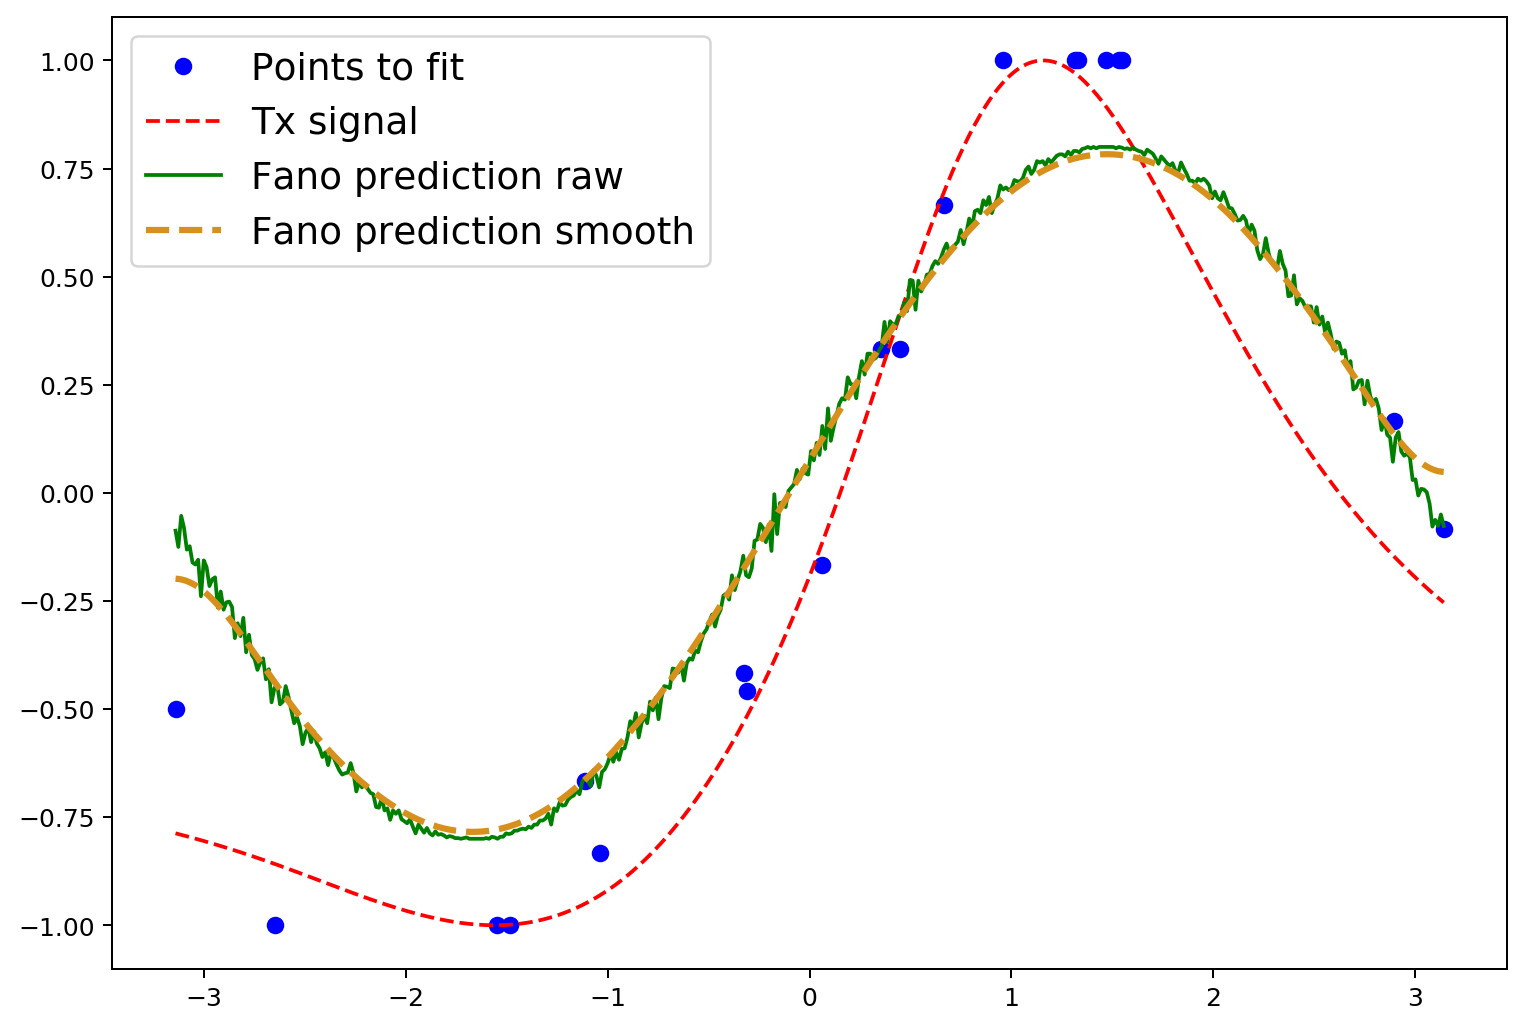

In [51]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = regressor.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [54]:
qsvr.score(X, y)

0.9610209170131668

# Custom Quantum Ridge Regressor

In [31]:
class QuantumRidge:
    
    def __init__(self, gamma, quantum_instance, feature_map):
        self.q_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
        self.gamma = gamma

    def fit(self, X_train, y_train):
        self.X_train = X_train
        n_train = y_train.size
        I = np.eye(n_train)
        K_train = self.q_kernel.evaluate(x_vec=X_train)
        K_train = K_train + self.gamma * I
        self.alpha = np.linalg.solve(K_train, y_train)

    def predict(self,X_test):
        K_test = self.q_kernel.evaluate(self.X_train, X_test).T
        prediction = K_test @ self.alpha
        return prediction
    
#    def score(self, X, y):
#        matrix = self.q_kernel.evaluate(x_vec=X)
#        spectral = SpectralClustering(2, affinity="precomputed")
#        cluster_labels = spectral.fit_predict(matrix)
#        cluster_score = normalized_mutual_info_score(cluster_labels, y)
#        return cluster_score

In [32]:
qr_norm = QuantumRidge(1.0, quantum_instance, feature_map)

qr_norm.fit(X,y)
y_pred = qr_norm.predict(X_)

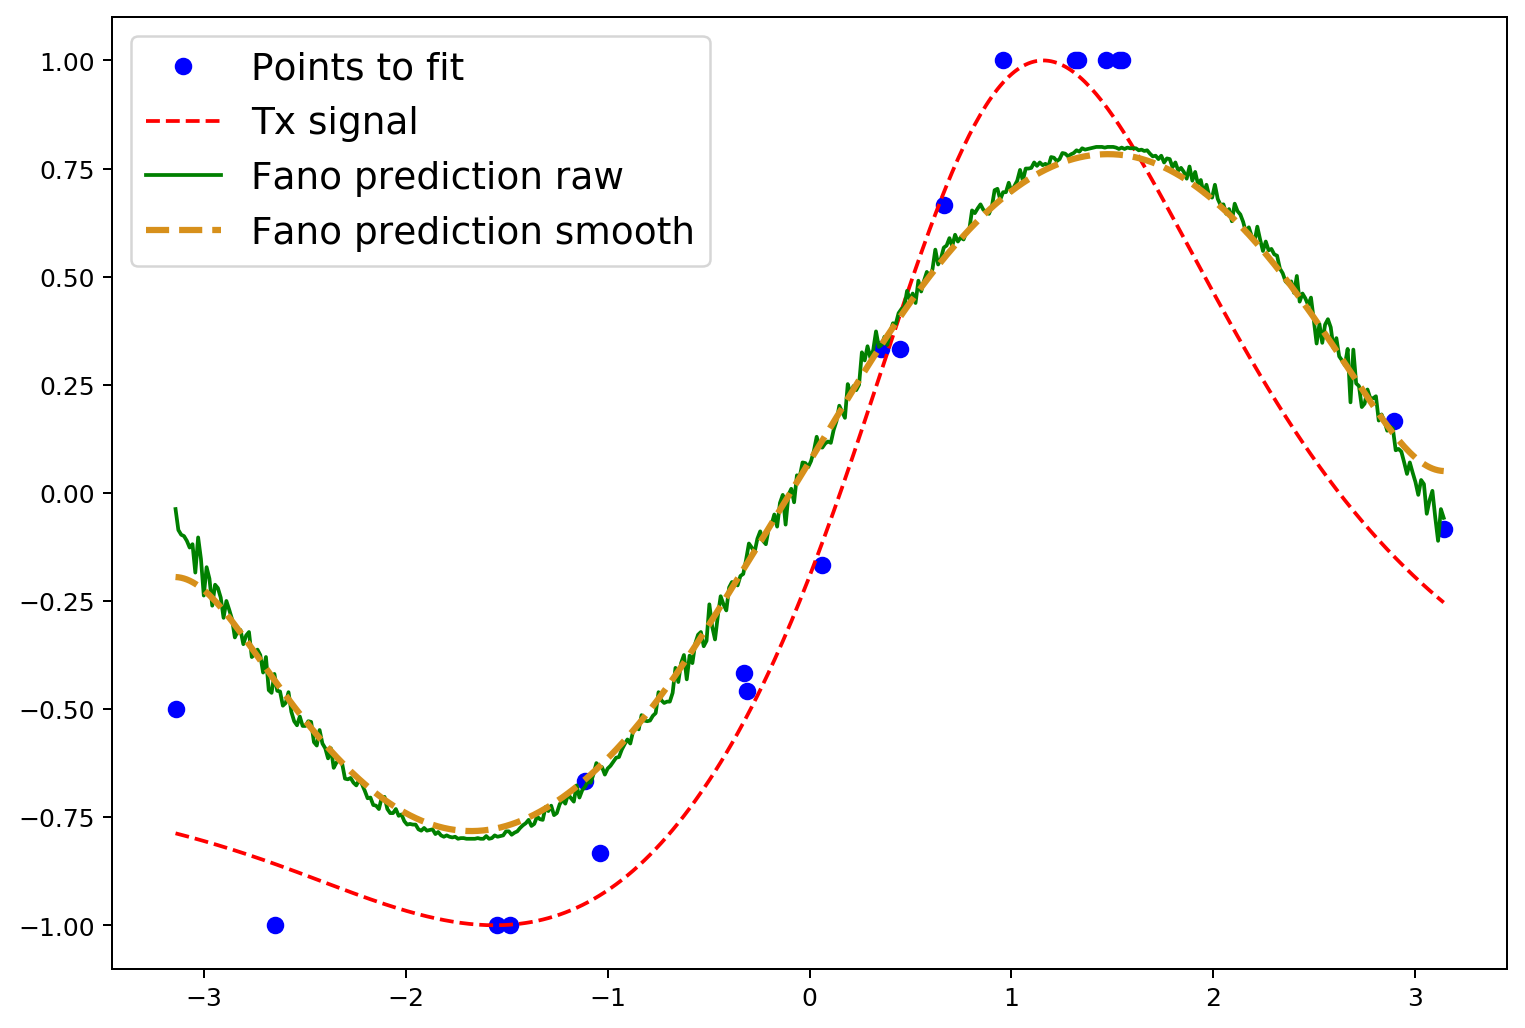

In [33]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = regressor.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [34]:
#qr_norm.score(X, y)
print("Score: %.10f" % r2_score(y_, y_predict))  

Score: 0.8280176139


## Quantum Classical Variational Algorithm Approach

In [35]:
quantum_kernel = KernelRidge(kernel=qkernel.evaluate)
quantum_kernel.fit(X, y)

KernelRidge(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002031D555D08>>)

In [36]:
score = quantum_kernel.score(X,y)
 
print('Kernel Ridge Regression Score: %.6f' % score)

Kernel Ridge Regression Score: 0.927524


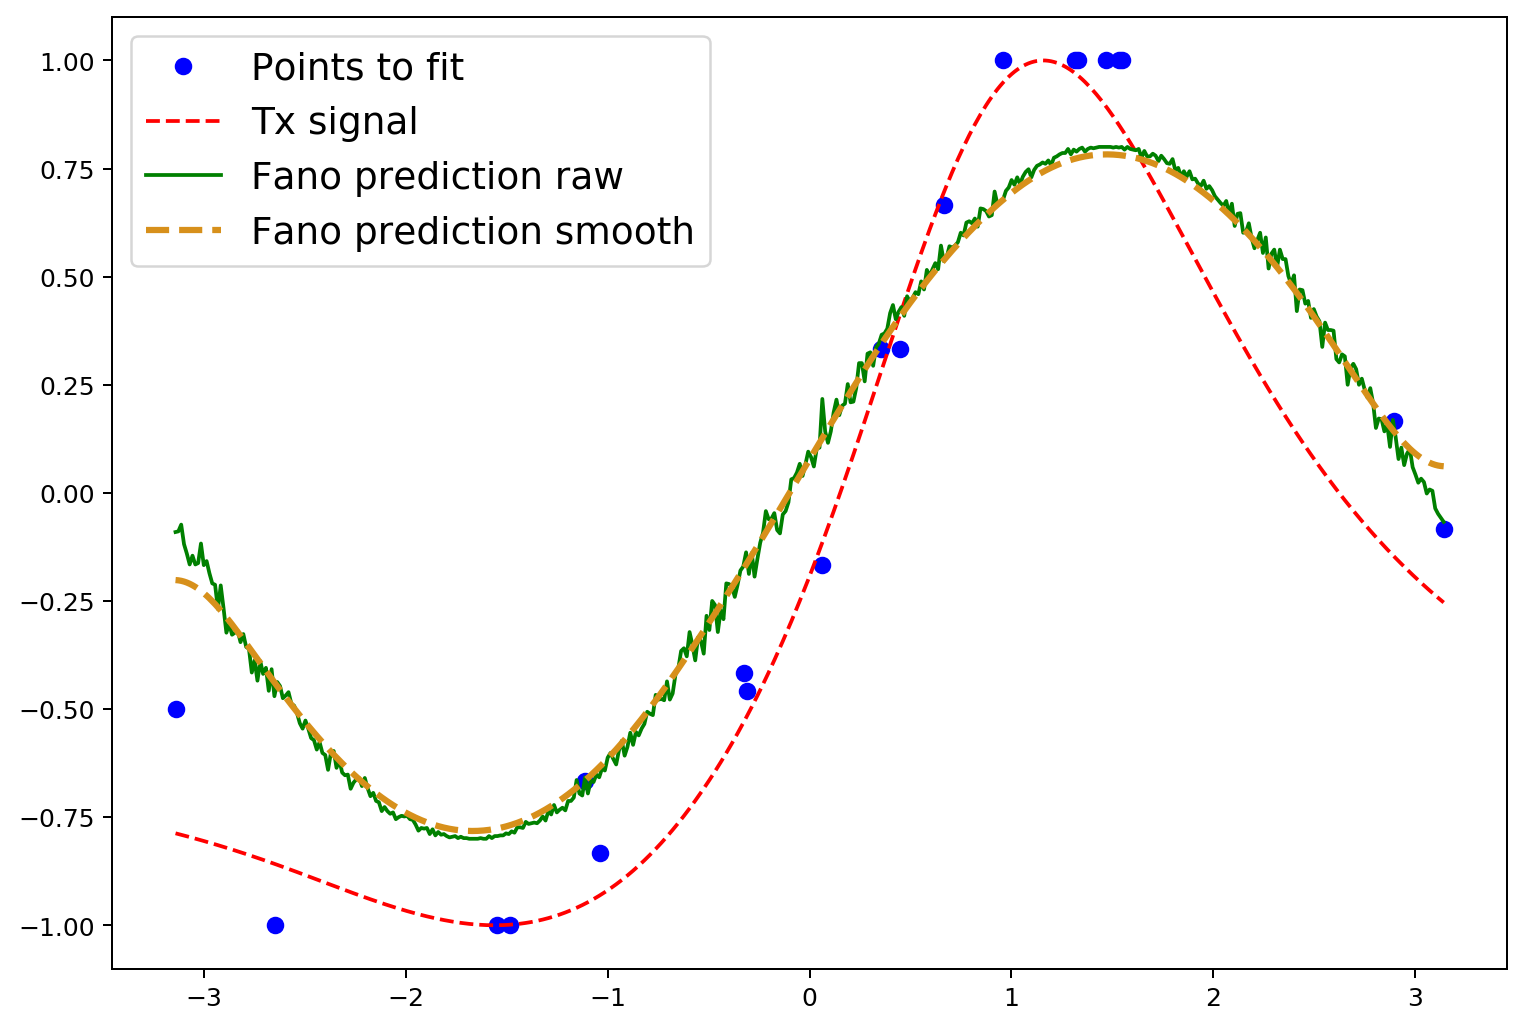

In [37]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = regressor.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [38]:
print("Score R2: %.10f" % r2_score(y_, y_predict))  

Score R2: 0.8276515363


## Keras Neural Network Linear Regression 

In [39]:
def create_model():
    
    layers = []
    #layers.append(Dense(64, kernel_initializer = "normal", activation = 'relu', input_shape = [1]))
    #layers.append(Dense(64, kernel_initializer = 'normal'))
    #layers.append(Dense(1))
    
    layers.append(Dense(64, activation = 'relu', input_shape = [1]))
    layers.append(Dense(64, activation = 'relu'))
    layers.append(Dense(1))
    
    new_model = Sequential(layers)
    
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.optimizers.SGD(lr=0.01)
    new_model.compile(loss ='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'])
    
    return new_model

model = create_model()

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Display training progress by printing a single dot for each completed epoch
@tf.autograph.experimental.do_not_convert
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

#history = model.fit(X, y, epochs=EPOCHS, validation_split = 0.2, verbose=0,  callbacks=[PrintDot()])
history = model.fit(X, y, epochs = EPOCHS, batch_size = 10,  validation_data = (X_,y_), verbose = 0,  callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,acc,val_loss,val_mean_absolute_error,val_mean_squared_error,val_acc,epoch
995,0.010002,0.077627,0.010002,0.3,0.018455,0.109628,0.018455,0.002222,995
996,0.010252,0.079040,0.010252,0.3,0.018574,0.110487,0.018574,0.002222,996
997,0.010095,0.078365,0.010095,0.3,0.018596,0.110637,0.018596,0.002222,997
998,0.010366,0.079088,0.010366,0.3,0.018887,0.111615,0.018887,0.002222,998
999,0.011029,0.080764,0.011029,0.3,0.019212,0.113063,0.019212,0.002222,999


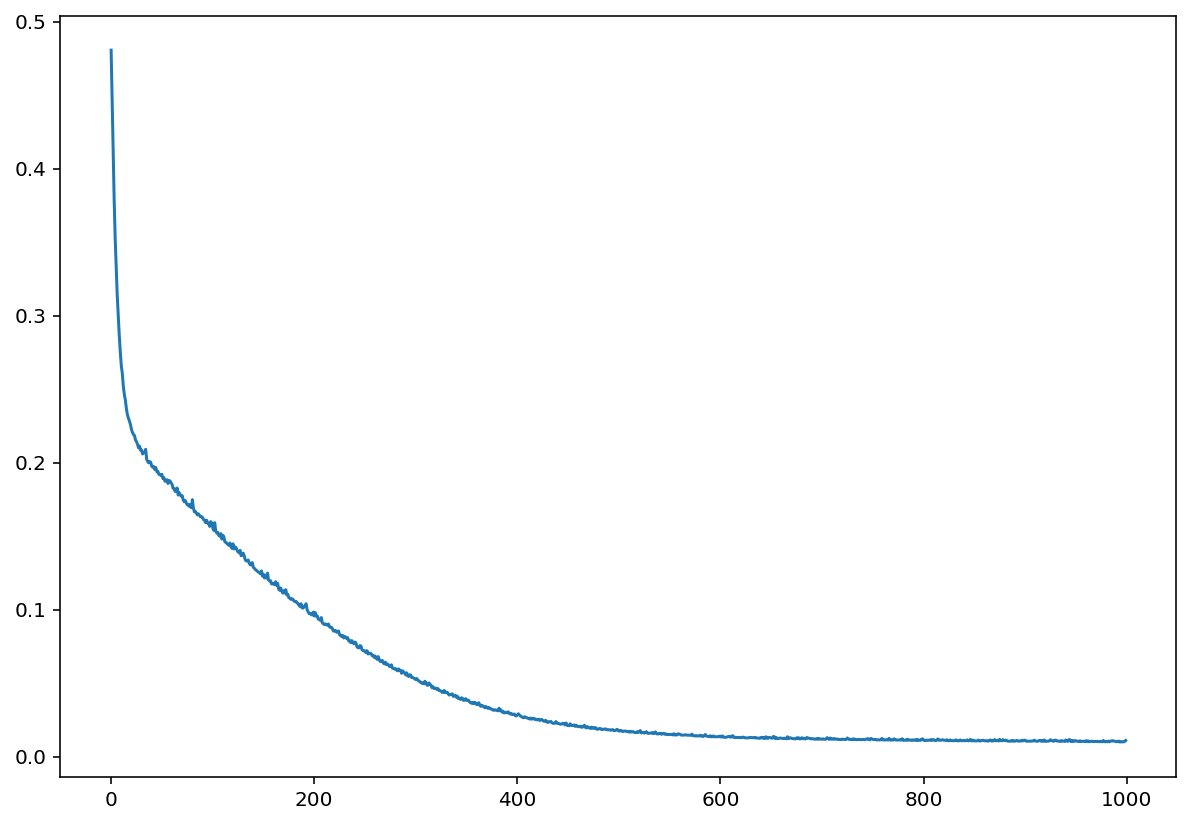

In [43]:
plt.plot( hist['epoch'] , hist['loss'] ) 
plt.show()

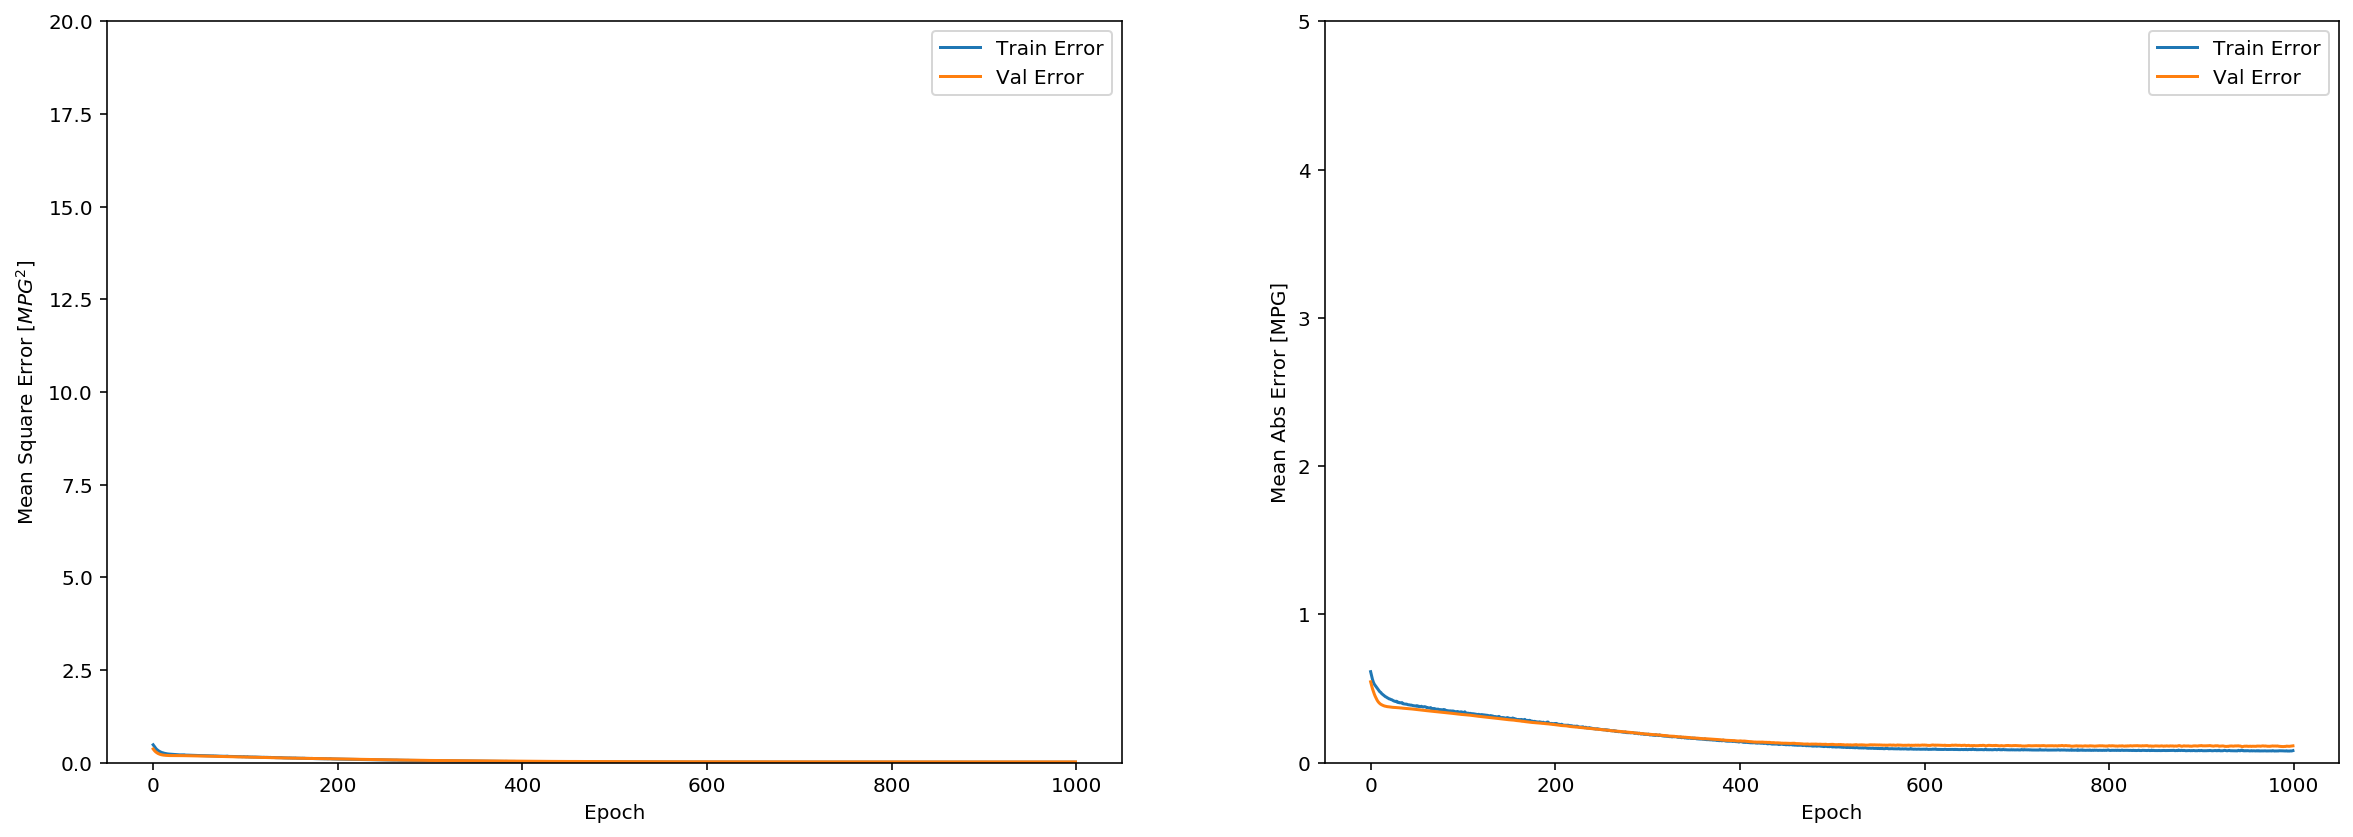

In [44]:
def plot_history(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,15))
    plt.subplot(2, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],  label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()


plot_history(history)

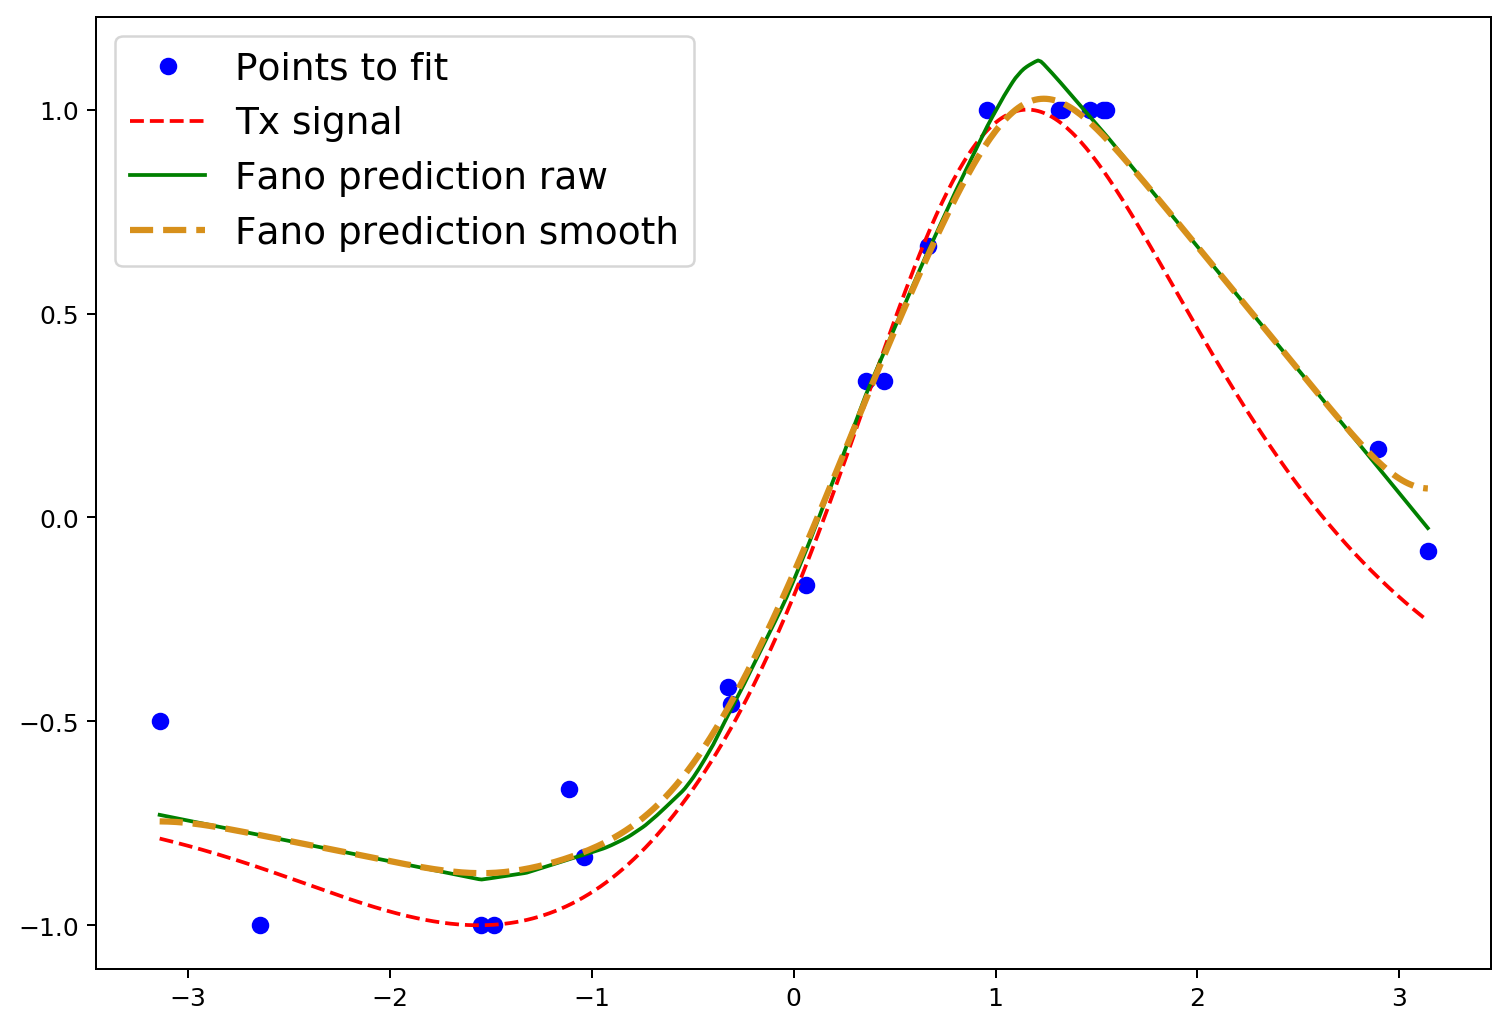

In [45]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = model.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [46]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.9611381183


# Evaluate Keras model

In [47]:
estimator = KerasRegressor(build_fn = create_model, epochs = 100, batch_size = 5, verbose = 0)

kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)

results = cross_val_score(estimator, y_, y_predict, cv = kfold)

print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -0.00 (0.00) MSE


In [48]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright